# Домашнее задание

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

Мы будем решать задачу сегментации изображений автомобилей. В этой задаче классов сегментации пять, а не два, как было на занятии. Весь код скачивания и подготовки данных реализован, в нем ничего менять не нужно. Однако советуем вам внимательно изучить весь код, так как задача сегментации в этом домашнем задании — не бинарная, а многоклассовая, и в этом коде есть некоторые отличия от кода, который был на занятии.

Перед вами стоят две задачи:
1. реализовать класс модели с заданными параметрами;
2. Подобрать и обучить такую архитектуру сети, чтобы IoU на валидационной выборке был > 0.5.

## Подготовка датасета

#### Скачивание данных

Запустите ячейки ниже, они скачают данные в колаб. Не изменяйте контент этих ячеек!

In [ ]:
! pip install wldhx.yadisk-direct

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.com/d/plvsPQhbb1vvEw) -o car_segmentation.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  441M  100  441M    0     0  12.0M      0  0:00:36  0:00:36 --:--:-- 14.1M


In [ ]:
! unzip -qq car_segmentation.zip

replace __MACOSX/._car-segmentation? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

#### Загрузка датасета

Импортируем нужные библиотеки:

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

Этот датасет для задачи сегментации представляет собой две папки с картинками.

- images:
    - img01.jpg
    - img02.jpg
    - ...
- masks:
    - img01.jpg
    - img02.jpg
    - ...


В папке images лежат RGB картинки, которые подаются сети на вход. В папке masks лежат карты сегментации к картинкам из папки images. img01.jpg из папки masks — это карта сегментации к картинке img01.jpg из папки images и т.д.

Карта сегментации — это двумерная картинка, на которой пиксели разных классов имеют разные значения. Например, откроем одну из картинок:

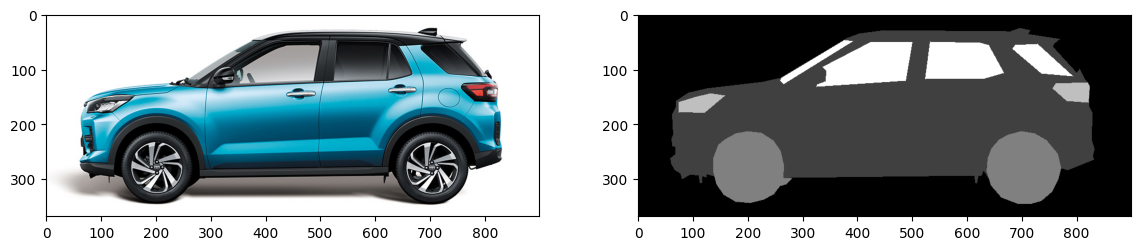

In [ ]:
# считываем картинку и ее карту сегментации
img = plt.imread('./car-segmentation/images/003.png')
img_seg = plt.imread('./car-segmentation/masks/003.png')

# отрисовываем две картинки рядом друг с другом
_, axes = plt.subplots(1,2, figsize=(14,10))
axes[0].imshow(img);
axes[1].imshow(img_seg, cmap='gray');

Как видно, на карте сегментации разными градиациями серого обозначены разные классы. Давайте посмотрим, сколько всего есть различных классов. Для этого посмотрим, сколько различных значений пикселей есть на картинке:

In [ ]:
np.unique(img_seg * 255)

array([0., 1., 2., 3., 4.], dtype=float32)

Как видим, классов сегментации у нас всего 5.

Давайте заведем словарь соответствия классам номерам:

In [ ]:
labels = {
    0: 'background',
    1: 'car',
    2: 'wheel',
    3: 'light',
    4: 'windows'
}

Код ниже для картинки отрисовывает изображения ее карт сегментации для каждого класса сегментации по отдельности. Можете попробовать запустить этот код для разных картинок.

[  0 255]


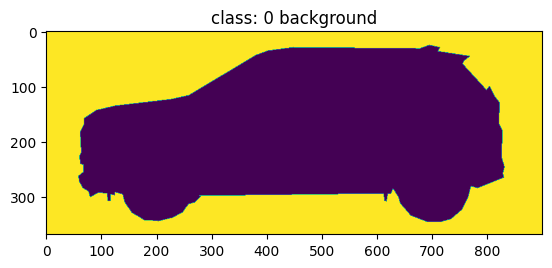

[  0 255]


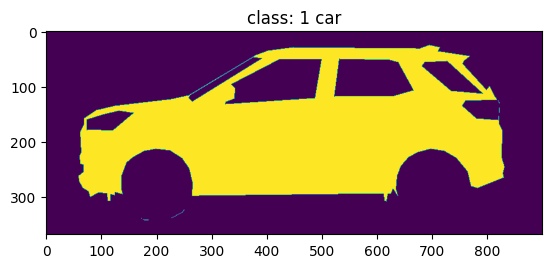

[  0 255]


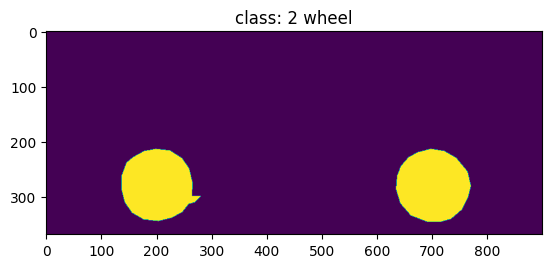

[  0 255]


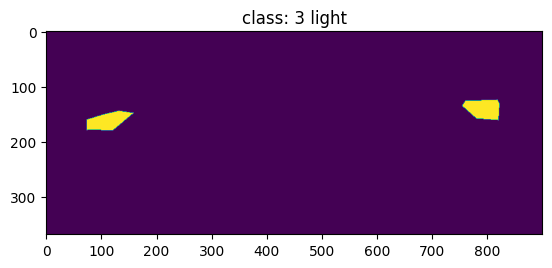

[  0 255]


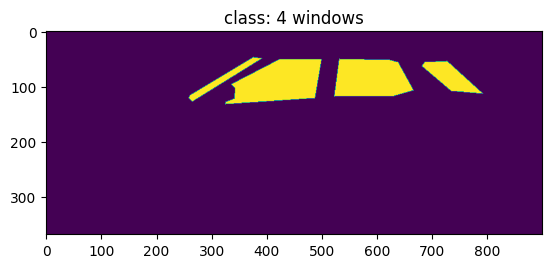

In [ ]:
# здесь выберите название картинки
img = '003'


for i in range(5):
    mask = plt.imread('./car-segmentation/masks/{}.png'.format(img)) * 255
    mask = np.where(mask == i, 255, 0)
    mask = mask
    print(np.unique(mask))
    plt.title(f'class: {i} {labels[i]}')
    plt.imshow(mask)
    plt.show()

#### Создание Dataset

Теперь создадим датасет из этих данных датасет для обучения модели. К сожалению, в PyTorch нет удобной функции для автоматического создания Dataset из данных для задачи сегментации, поэтому его придется написать вручную.

Для начала создадим два списка:
- список с путями до RGB картинок;
- список с путями до карт сегментаций этих картинок;

In [ ]:
images = []
segmentation_masks = []

for img_name in os.listdir('./car-segmentation/images/'):
    images.append('./car-segmentation/images/' + img_name)

for img_name in os.listdir('./car-segmentation/masks/'):
    segmentation_masks.append('./car-segmentation/masks/' + img_name)

Отсортируем списки путей до картинок и карт сегментаций, чтобы получить стабильный порядок:

In [ ]:
images = sorted(images)
segmentation_masks = sorted(segmentation_masks)

Теперь создадим кастомный датасет torch.utils.data.Dataset для удобной работы c нашими данными в PyTorch.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

Создаем класс для кастомного датасета.

In [ ]:
class CarsDataset(Dataset):
    def __init__(self, images, segmentation_masks):

        self.images = images
        self.segmentation_masks = segmentation_masks

        self.images_transforms = transforms.Compose([
            transforms.Resize((256, 256)), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # значения пикселей картинки нормализуются
        ])

        self.masks_transforms = transforms.Compose([
            # используем InterpolationMode.NEAREST, чтобы при изменении размера
            # маски сегментации не менялись номера классов
            transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST), # размер каждой картинки будет приведен к 256*256
            transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
        ])

    def __getitem__(self, index):
        '''
        этот метод должен по заданному номеру пары картинка-сегментация (index)
        возвращать эту пару. Этот метод обязательно нужно реализовывать во всех
        кастомных классах Dataset. Перед тем, как выдать на выходе
        пару картинка-сегментация, можно применить к картинкам любые преобразования:
        например, знакомую нам аугментацию.
        '''

        # загружаем нужные картинку и ее карту сегментации
        img = Image.open(self.images[index]).convert('RGB')
        mask = Image.open(self.segmentation_masks[index])

        # # применяем предобработку к RGB картинке
        img = self.images_transforms(img)
        # # применяем предобработку к маске сегментации
        mask = self.masks_transforms(mask)*255

        # # делим маску сегментации на 13 бинарных масок сегментации
        # # отдельно для каждого класса
        masks = []

        # вытаскиваем пиксели, принадлежащие классам unlabeled, building, road и car.
        for i in range(5):
            # генерируем бинарную маску сегментации для текущего класса i
            cls_mask = torch.where(mask==i, 1, 0)
            masks.append(cls_mask[0,:,:].numpy())

        masks = torch.as_tensor(masks, dtype=torch.uint8)
        # схлопываем бинарные карты сегментации в одну
        masks = torch.argmax(masks, axis=0)

        # возвращаем пару: картинка — ее маска сегментации на 5 классов
        return (img, masks)

    def __len__(self):
        '''
        этот метод должен возвращать количество пар картинка-сегментация в датасете
        '''
        return len(self.images)

Проверим, что наш Dataset работает. Заведем переменную датасета и возьмем нулевой элемент. Отрисуем картинку и одну из ее бинарных карт сегментации.

torch.Size([3, 256, 256]) torch.Size([256, 256])


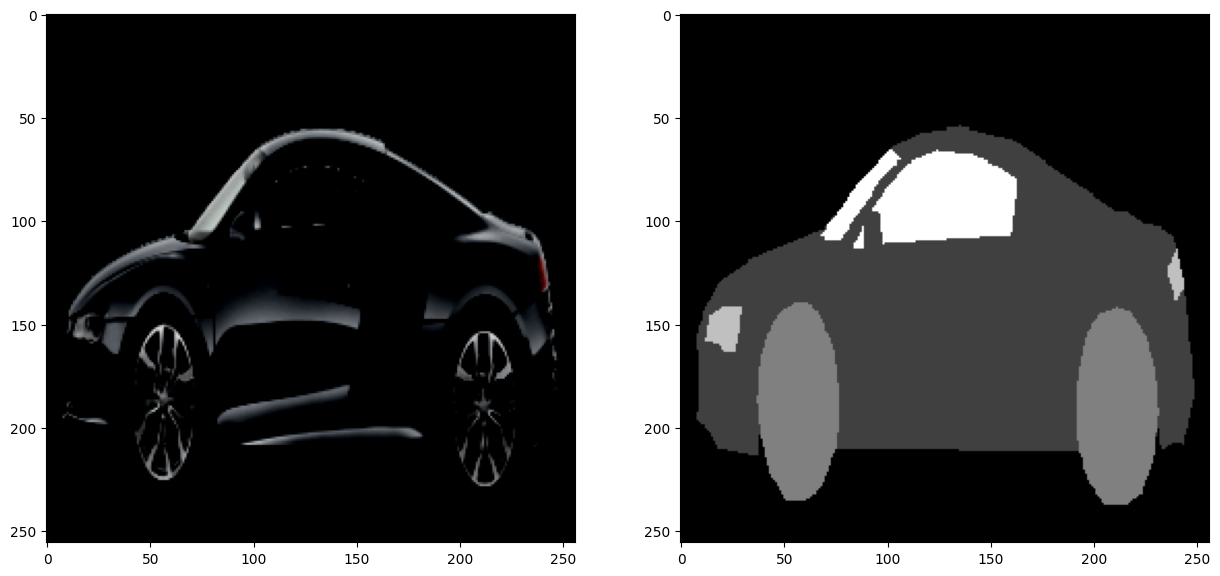

In [ ]:
dataset = CarsDataset(images, segmentation_masks)

# dataset[0] — это вызов метода __getitem__(0)
img, mask = dataset[3]

print(img.shape, mask.shape)

# отрисовываем картинку
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
# показываем бинарную маску сегментации
ax[1].imshow(mask, cmap='gray')
plt.show()

Разделим выборку на train и val:

In [ ]:
train_size = int(len(dataset) * 0.8)
val_size = len(dataset) - train_size

g_cpu = torch.Generator().manual_seed(8888)
train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size], generator=g_cpu)

И заведем даталоадеры:

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

## Задача #1. Создание модели

Проверим, доступен ли нам GPU:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Нужно объявить класс модели. Наша задача сегментации частей машины сложнее, чем задача сегментации родинок, которую мы решали на занятии. Поэтому нам потребуется модель чуть посложнее.

Модели с большим количеством слоев обычно состоят из нескольких блоков похожего устройства. Наша модель типа U-Net будет состоять из блоков двух типов: один тип для части-енкодера, второй тип для части-декодера.

Наша модель будет выглядеть так, как показано на картинке выше. Она будет состояить из трех encoder и трех decoder блоков. В модели будут два skip connection:
- из выхода первого encoder блока ко входу третьего decoder блока;
- из выхода второго encoder блока ко входу второго decoder блока;

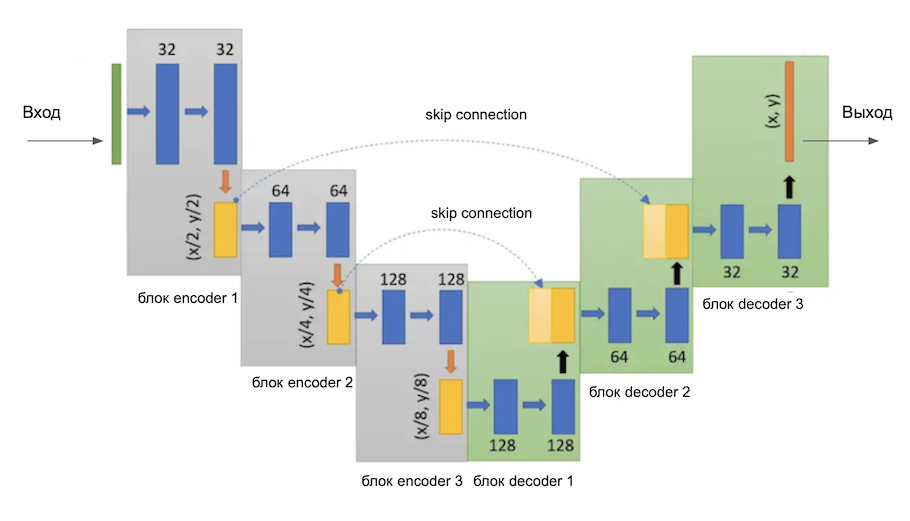

In [ ]:
def encoder_block(in_channels, out_channels, kernel_size, padding):
    '''
    блок, который принимает на вход карты активации с количеством каналов in_channels,
    и выдает на выход карты активации с количеством каналов out_channels
    kernel_size, padding — параметры conv слоев внутри блока
    '''

    # Реализуйте блок вида conv -> relu -> max_pooling.
    # Параметры слоя conv заданы параметрами функции encoder_block.
    # MaxPooling должен быть с ядром размера 2.
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    return block

def decoder_block(in_channels, out_channels, kernel_size, padding):
    '''
    блок, который принимает на вход карты активации с количеством каналов in_channels,
    и выдает на выход карты активации с количеством каналов out_channels
    kernel_size, padding — параметры conv слоев внутри блока
    '''

    # Реализуйте блок вида conv -> relu -> upsample.
    # Параметры слоя conv заданы параметрами функции encoder_block.
    # Upsample должен быть со scale_factor=2. Тип upsampling (mode) можно выбрать любым.
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Upsample(scale_factor=2, mode='bilinear')
    )

    return block

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        '''
        параметры:
            - in_channels: количество каналов входного изображения
            - out_channels: количество каналов выхода нейросети
        '''
        super().__init__()

        self.enc1_block = encoder_block(in_channels, 32, 7, 3)
        self.enc2_block = encoder_block(32, 64, 3, 1)
        self.enc3_block = encoder_block(64, 128, 3, 1)

        # поймите, какие параметры должны быть у dec1_block, dec2_block и dec3_block
        # dec1_block должен быть симметричен блоку enc3_block
        # dec2_block должен быть симметричен блоку enc2_block
        # но обратите внимание на skip connection между выходом enc2_block и входом dec2_block
        # (см что подается на вход dec2_block в функции forward)
        # какое количество карт активации будет тогда принимать на вход dec2_block?
        # также обратите внимание на skip connection между выходом enc1_block и входом dec3_block
        # (см что подается на вход dec3_block в функции forward)
        # какое количество карт активации будет тогда принимать на вход dec3_block?
        self.dec1_block = decoder_block(128, 64, 3, 1)  # Симметрично enc3_block
        self.dec2_block = decoder_block(128, 32, 3, 1)  # Результат декодера будет соединяться с enc2_block
        self.dec3_block = decoder_block(64, out_channels, 3, 1)  # Результат декодера будет соединяться с enc1_block

    def forward(self, x):

        # downsampling part
        enc1 = self.enc1_block(x)
        enc2 = self.enc2_block(enc1)
        enc3 = self.enc3_block(enc2)

        dec1 = self.dec1_block(enc3)
        # из-за skip connection dec2 должен принимать на вход сконкатенированные карты активации
        # из блока dec1 и из блока enc2.
        # конкатенация делается с помощью torch.cat
        dec2 = self.dec2_block(torch.cat([dec1, enc2], 1))
        # из-за skip connection dec3 должен принимать на вход сконкатенированные карты активации
        # из блока dec2 и из блока enc1.
        # конкатенация делается с помощью torch.cat
        dec3 = self.dec3_block(torch.cat([dec2, enc1], 1))

        return dec3


Ячейка ниже проверяет, что модель написана и работает правильно:

In [ ]:
# проверка работы функции enc_block
enc_block = encoder_block(5, 5, 7, 3)
assert len(enc_block) == 3, \
 "неверная реализация encoder block. Проверьте количество слоев"
assert 'Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)' in str(enc_block), \
 "неверная реализация encoder block. Проверьте параметры слоя conv"
assert 'ReLU()' in str(enc_block), \
 "неверная реализация encoder block. Проверьте, что не забыли ReLU после conv"
assert 'MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)' in str(enc_block), \
 "неверная реализация encoder block. Проверьте, что не забыли MaxPool после ReLU и его параметры (размер ядра)"

# проверка работы функции dec_block
dec_block = decoder_block(5, 5, 7, 3)
assert len(dec_block) == 3, \
 "неверная реализация decoder block. Проверьте количество слоев"
assert 'Conv2d(5, 5, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3)' in str(dec_block), \
 "неверная реализация decoder block. Проверьте параметры слоя conv"
assert 'ReLU()' in str(dec_block), \
 "неверная реализация decoder block. Проверьте, что не забыли ReLU после conv"
assert 'Upsample(scale_factor=2.0' in str(dec_block), \
 "неверная реализация decoder block. Проверьте, что не забыли Upsample после ReLU и его параметры (scale_factor)"

# проверка, что модель UNet собрана верно
random_tensor= torch.Tensor(np.random.random((32, 10, 32, 32)))
model = UNet(10, 10)
out = model(random_tensor)

AssertionError: неверная реализация encoder block. Проверьте количество слоев

### Сдача задания #1

Если обе ячейки отработали без ошибок, можно сдавать задание в первую задачу на Я.Контесте. Для этого нужно скопировать класс UNet в нужное место в submission_template09.py и отправить submission_template09.py в Я.Контест.

## Задание #2. Обучение модели

Если вы запустите обучение той модели, которую мы реализовали выше, с помощью кода ниже, вы увидите, что она показывает не очень большой IoU (около 0.22).

И в этом задании вам нужно подобрать архитектуру модели UNet так, чтобы после обучения сети на тренировочной выборке сеть получала хорошую метрику IoU. Изменяйте код модели выше, запускайте ее обучение и тест на валидационной выборке с помощью кода ниже. Вы получите:
- 0.5 балла, если ваша модель получает IoU > 0.4 на валидационной выборке;
- 1 балл (максимальный), если ваша модель получает IoU > 0.5 на валидационной выборке.

Вот какие идеи можно попробовать, чтобы улучшить модель:
- Добавить слои batchnorm в блоки encoder и decoder. Обычно эти слои добавляют между conv и relu.
- Чтобы получить еще большую метрику, можно попробовать обучать модель иное количество эпох/подобрать параметр learning rate

Двух этих идей должно хватить, чтобы обеспечить вам значение IoU > 0.5 и успешную сдачу задания. Но если хочется улучшить модель еще сильнее, можно пробовать другие идеи. Например, можно также пробовать увеличивать количество слоев: например, добавить еще сверточных слоев внутри блоков encoder/decoder или увеличить количество блоков. Однако в данном случае это не кажется логичным, так как наша обучабщая выборка довольно мала, и глубокая сеть легко переобучится.

Также хорошей идеей может быть добавить подсчет метрики IoU после каждой эпохи обучения. Так вы будете прямо во время обучения сети видеть, как меняется значение метрики на валидации.

Функция обучения модели. Она полностью реализована, ничего менять не нужно

In [ ]:
from IPython.display import clear_output

def train(model, opt, loss_fn, epochs, train_loader, val_loader):

    for epoch in range(epochs):
        # печатаем номер текущей эпохи
        print('* Epoch %d/%d' % (epoch+1, epochs))

        # 1. Обучаем сеть на картинках из train_loader
        model.train()  # train mode

        avg_train_loss = 0
        for i, (X_batch, Y_batch) in enumerate(train_loader):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)

            # считаем лосс, делаем шаг оптимизации сети
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            avg_train_loss += loss / len(train_loader)

        # выводим средний лосс на тренировочной выборке за эпоху
        print('avg train loss: %f' % avg_train_loss)

        # 2. Тестируем сеть на картинках из val_loader
        model.eval()

        avg_val_loss = 0
        for i, (X_batch, Y_batch) in enumerate(val_loader):
            # переносим батч на GPU
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # получаем ответы сети на батч
            Y_pred = model(X_batch)
            # считаем лосс на батче
            loss = loss_fn(Y_pred, Y_batch)

            avg_val_loss += loss / len(val_loader)

        # выводим средний лосс на валидационных данных
        print('avg val loss: %f' % avg_val_loss)


        # 3. Визуализируем ответы сети на шести картинках из валидационных данных

        # получаем один батч из data_val
        X_val, Y_val = next(iter(val_loader))
        # получаем ответ сети на картинки из батча
        Y_pred = model(X_val.to(device))
        Y_hat = Y_pred.detach().cpu().numpy()
        Y_hat = np.argmax(Y_hat, axis=1)

        # удаляем предыдущую визуализацию
        clear_output(wait=True)

        # визуализируем исходные картинки, верный ответ и ответ нашей модели
        # визуализация ответов сети
        clear_output(wait=True)
        _, axes = plt.subplots(7, 6, figsize=((5+2)*4, 7*4))
        for k in range(6):

            # отрисовываем 6 картинок, поданных на вход сети
            # картинки нормализованы, поэтому могут выглядеть непривычно
            axes[0][k].imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray', aspect='auto')
            axes[0][k].title.set_text('Input')

            # отрисовываем правильную маску сегментации для шести картинок выше
            axes[1][k].imshow(Y_val[k].numpy(), cmap='gray', aspect='auto')
            axes[1][k].title.set_text('Real Map')

            # отрисовываем ответы сети для каждого из пяти классов сегментации в отдельности
            for j in range(5):
                axes[j+2][k].imshow(np.where(Y_hat[k]==j, 1, 0), cmap='gray', aspect='auto')
                axes[j+2][k].title.set_text('Output for {}'.format(labels[j]))
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_val_loss))
        plt.show()

Запустим обучение сети. В процессе обучения после каждой эпохи будут выводиться шесть столбцов картинок. Каждый столбец — текущий результат сегментации одной из картинок валидационного датасета:
- первая строка — начальная картинка;
- вторая строка — ground-truth маска сегментации;
- третья-седьмая строки — маски, выданные нейросетью для каждого из пяти классов сегментации.

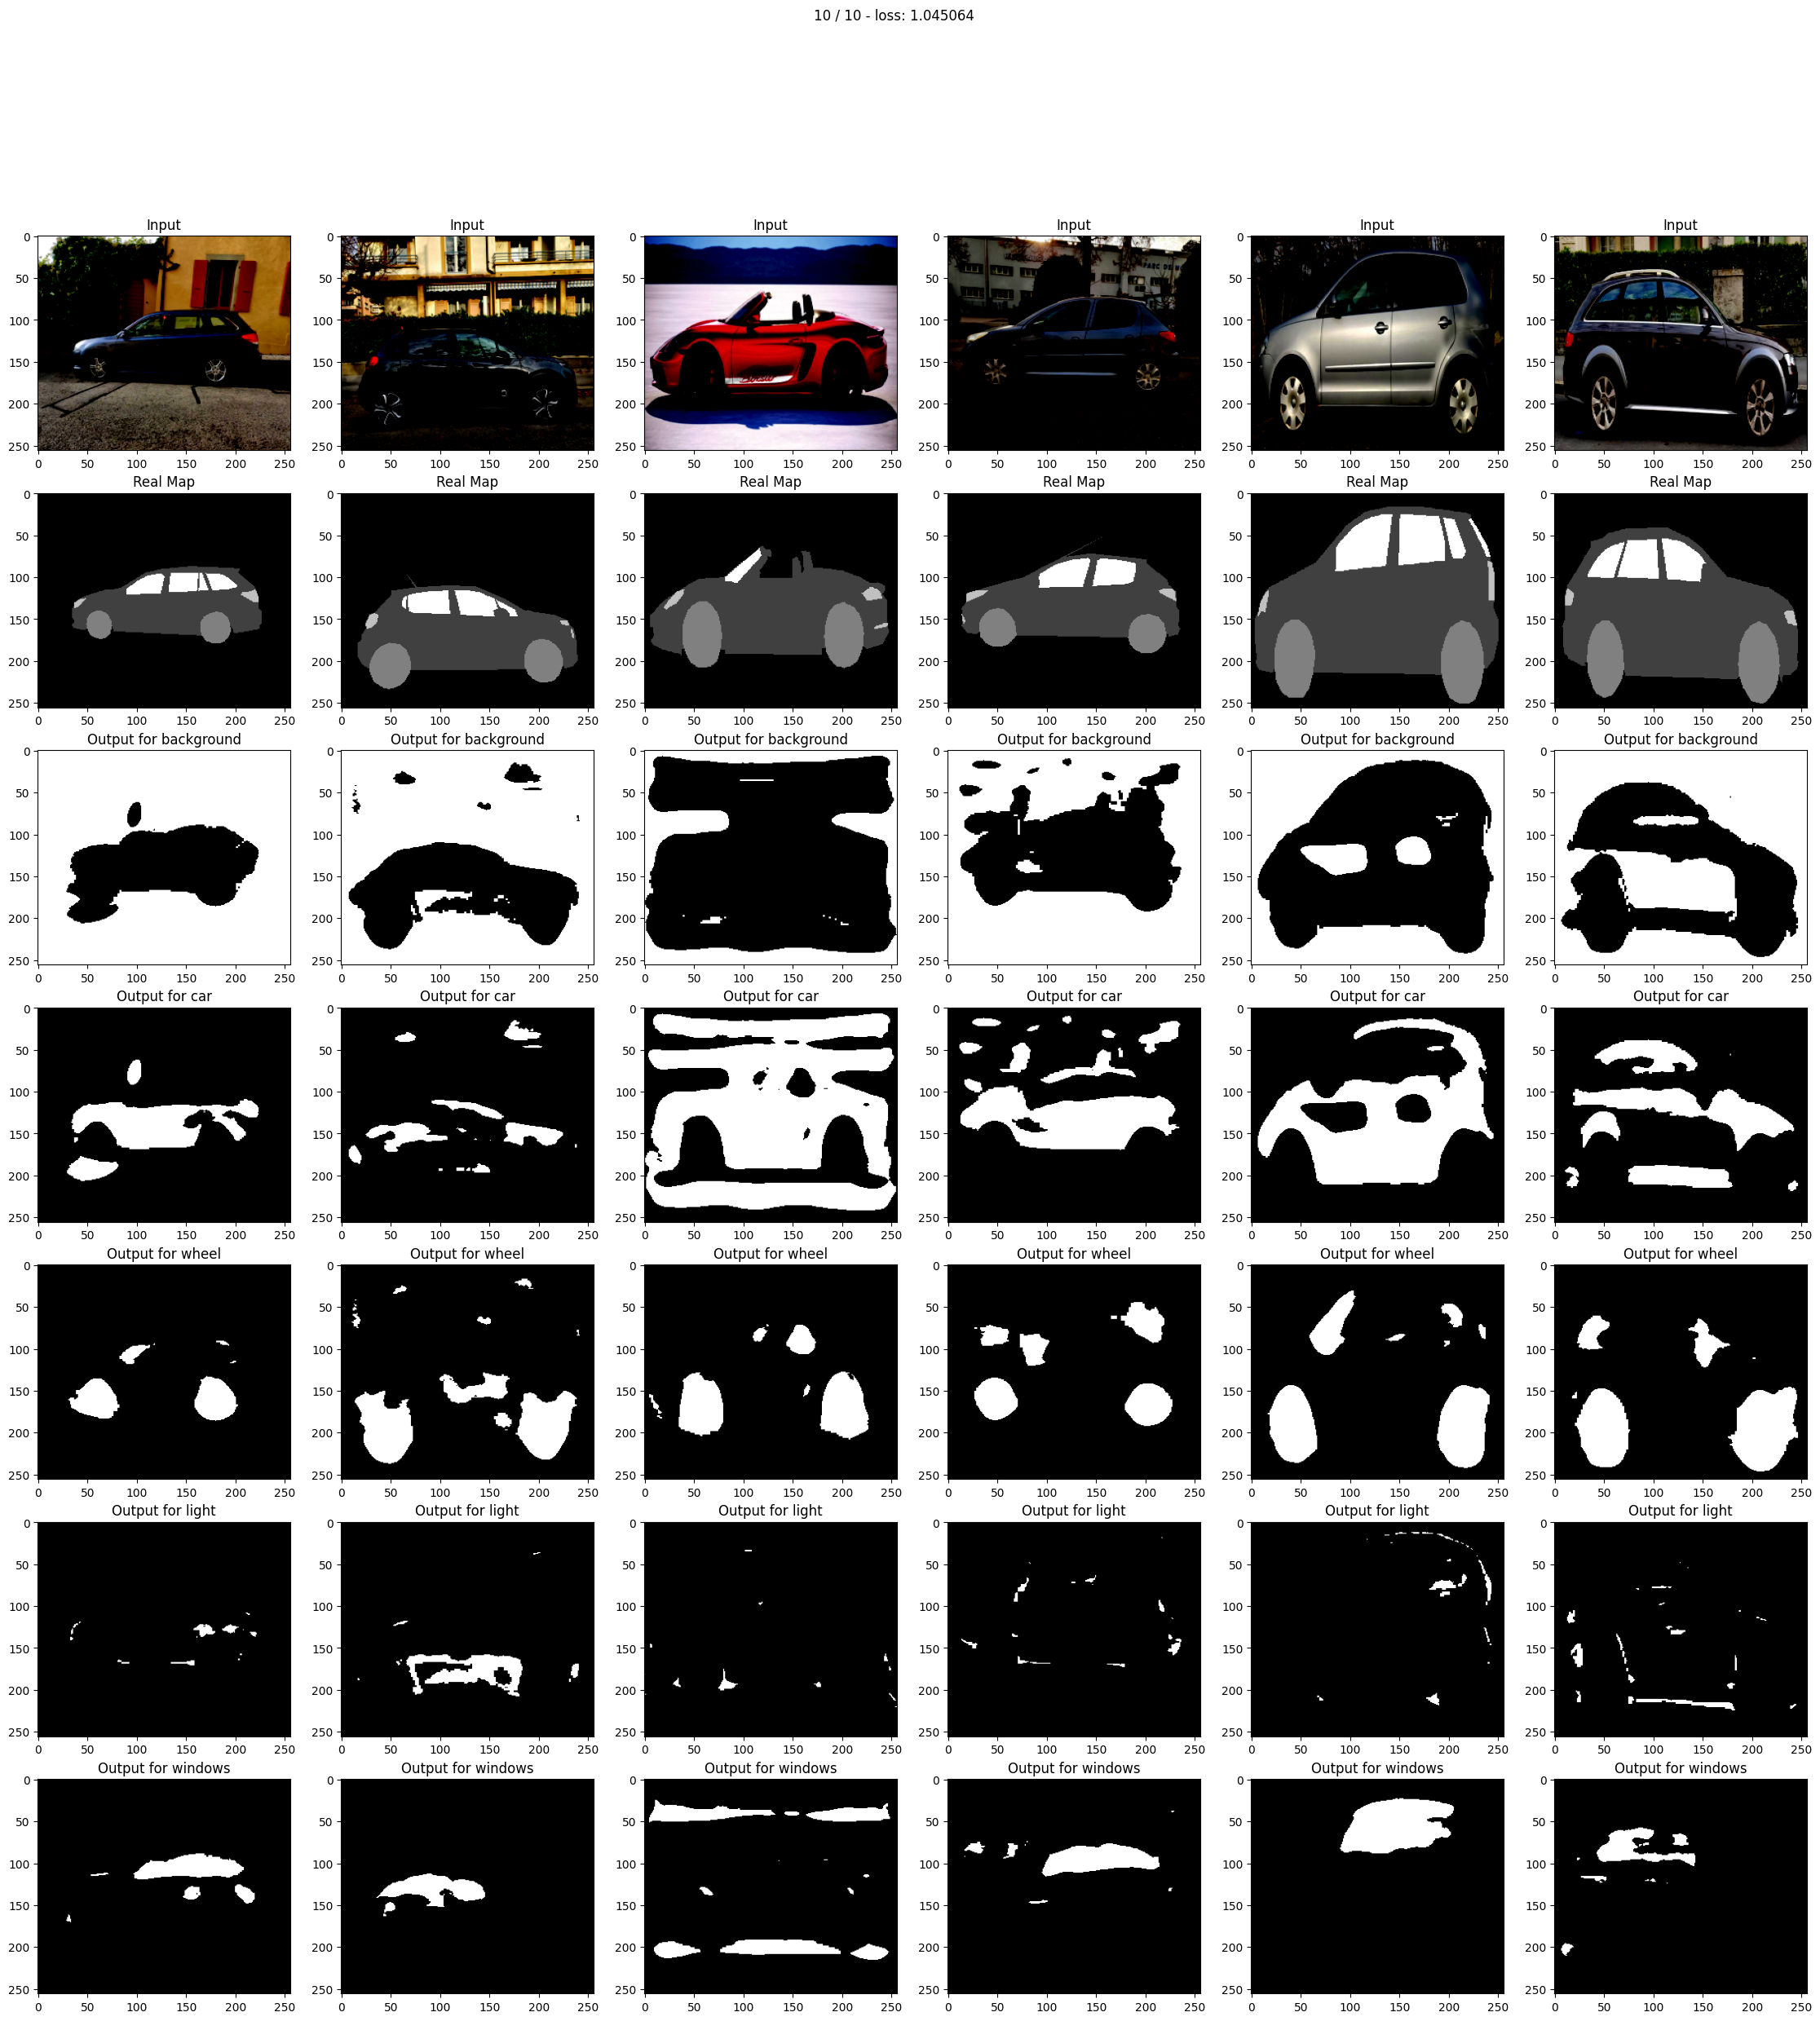

In [ ]:
# подумайте: какие параметры in_channels, out_channels должны быть у нашей модели?
model = UNet(3, 5).to(device)
# так как сегментация многоклассовая, обучаем с помощью кросс-энтропии
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
# запускаем обучение на 10 эпох
train(model, opt, loss, 10, train_loader, val_loader)

### Метрика качества IoU

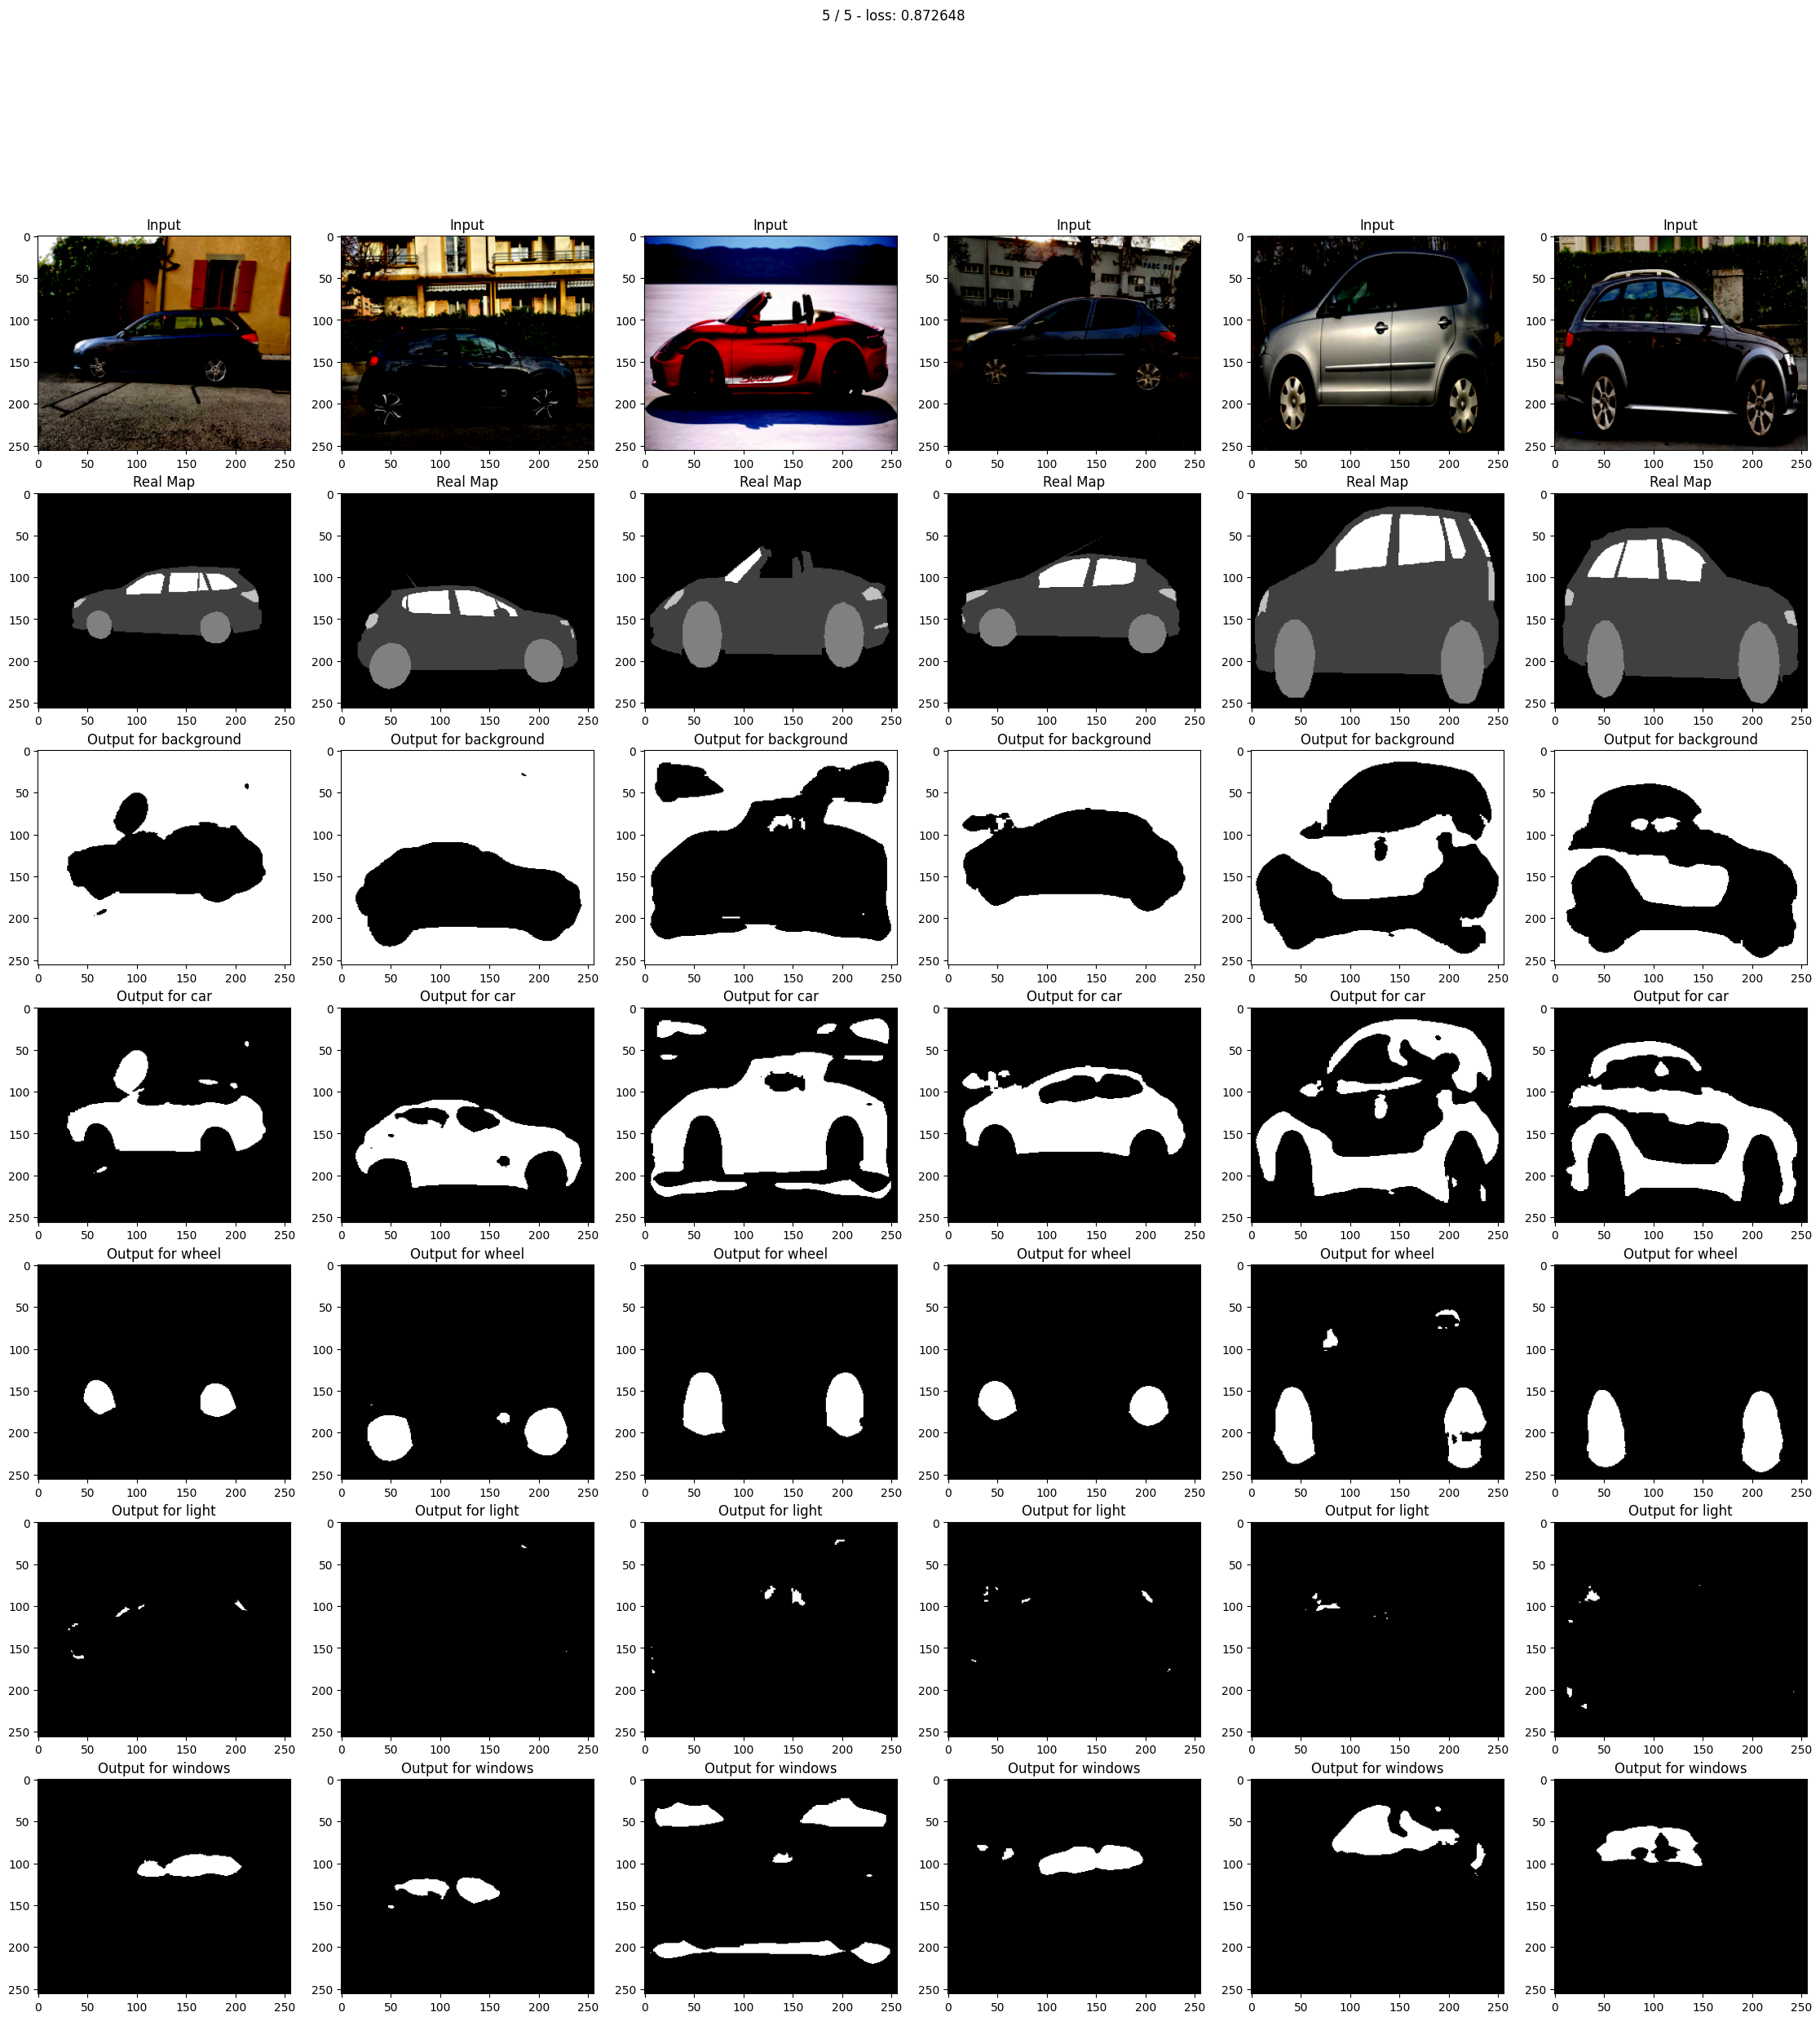

In [ ]:
train(model, opt, loss, 5, train_loader, val_loader)

Код ниже вычисояет метрику качества IoU вашей модель model на валидационной выборке. Чтобы получить балл за задание, ваша модель должна выдавать IoU > 0.5

In [ ]:
! pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex
# наша задача — многоклассовая сегментация, поэтому параметрtask='multiclass'
# также нужно задать количество классов — в нашем случае их 5
jaccard = JaccardIndex(task='multiclass', num_classes=5).to(device)

Функция подсвета метрики на валидационном датасете:

In [ ]:
def evaluate(model, dataloader, loss_fn, metric_fn):

    losses = []
    metrics = []

    for i, batch in enumerate(dataloader):

        # получаем текущий батч
        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            # получаем выход модели
            logits = model(X_batch)

            # считаем лосс по батчу
            loss = loss_fn(logits, y_batch)
            losses.append(loss.item())

            # считаем метрику по батчу
            metric = metric_fn(logits, y_batch)
            metrics.append(metric.item())

    # возвращает средние значения лосса и метрики
    return np.mean(losses), np.mean(metrics)

In [ ]:
evaluate(model, val_loader, loss, jaccard)

(0.8726483583450317, 0.5389051834742228)

### Сдача задания #2

Запустите код ниже для генерации посылки. Полученный файл сдайте в Я.Контест в качестве решения.

In [ ]:
import os

def get_predictions(model, dataloader):

    predictions = []

    for i, batch in enumerate(dataloader):

        X_batch, y_batch = batch
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        with torch.no_grad():
            logits = model(X_batch)
            Y_hat = logits.detach().cpu().numpy()
            Y_hat = np.argmax(Y_hat, axis=1)
            predictions.extend(Y_hat)

    return predictions

predicted_labels = get_predictions(model, val_loader)

np.save('submission_hw09.npy', predicted_labels, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw09.npy`')

Ответ сохранен в файл `submission_hw09.npy`
